In [1]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# 1. Sequential model

from tensorflow import keras
from tensorflow.keras import layers

# model = keras.Sequential([
#     layers.Dense(64, activation="relu"),
#     layers.Dense(10, activation="softmax")
# ])

model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
# model.weights
# model.summary()

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[-0.28258926, -0.13357973,  0.20892453,  0.018273  , -0.11281256,
         -0.24692453,  0.01643696,  0.20895487, -0.04892865,  0.00041088,
          0.13301829,  0.20019895,  0.10793653, -0.25660124,  0.03948951,
         -0.15271226, -0.03040755, -0.20267057,  0.15192458, -0.17275631,
          0.0217883 ,  0.26007944,  0.09576795, -0.11706814, -0.03374889,
         -0.05931512, -0.28442112,  0.08937699,  0.12142399,  0.02781481,
          0.06788644, -0.0510662 ,  0.2879433 ,  0.10670087, -0.121788  ,
         -0.2984251 ,  0.16302824, -0.1482835 ,  0.17302808,  0.2979896 ,
         -0.10112728, -0.19849361, -0.18329939, -0.27889147,  0.1671648 ,
         -0.15688929,  0.22444034, -0.19364485,  0.2273612 , -0.01020196,
          0.11712009,  0.03188318,  0.22104424, -0.11881295, -0.2412781 ,
         -0.27234718,  0.18040767,  0.20407128, -0.07189794,  0.10815993,
          0.01428425, -0.06463078, -0.26428

40/40 [==============================] - 0s 7ms/step - loss: 25.1397 - priority_loss: 0.3249 - department_loss: 24.8148 - priority_mean_absolute_error: 0.4929 - department_accuracy: 0.0617


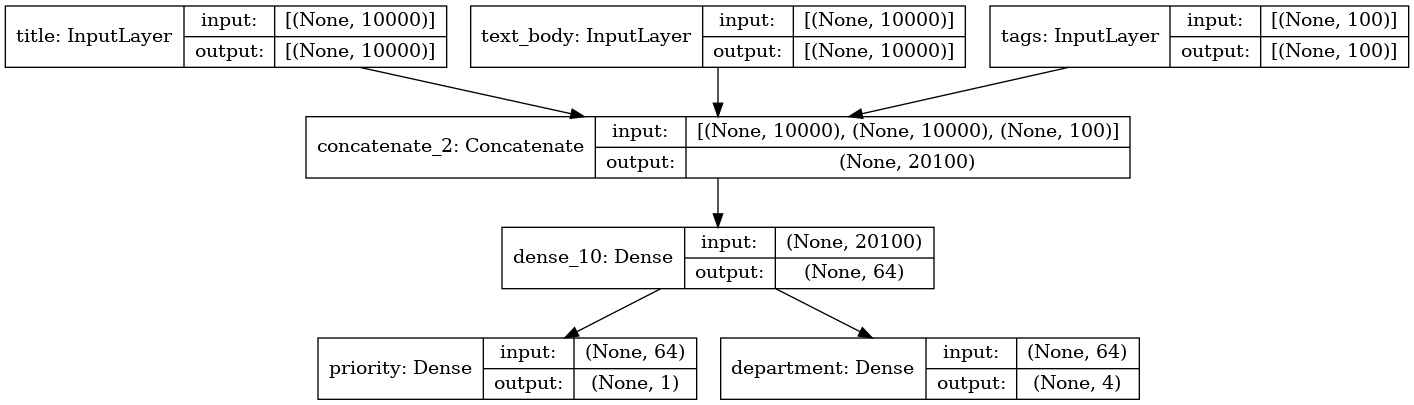

In [9]:
# 2. Functional API model
import numpy as np

vocabulary_size = 10000
num_tags = 100
num_departments = 4

# model 
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

# data
num_samples = 1280
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

# compile fit eval
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})
keras.utils.plot_model(model, show_shapes=True)

In [7]:
# 3 Subclassing

class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

model = CustomerTicketModel(num_departments=4)
priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 [==============================] - 1s 9ms/step - loss: 31.4203 - output_1_loss: 0.3321 - output_2_loss: 31.0882 - output_1_mean_absolute_error: 0.5004 - output_2_accuracy: 0.5508


### 1. Sequential과 functional의 차이
Sequential은 간편하게 사용가능하지만, single input & output의 한계점을 가지고 있지만 functional은 functinal 형태로 component들을 쌓아서, model을 처리가능합니다. 이를 통해서 component 간의 연결을 쉽게 사용가능하며, reuse를 할 수 있으며, dependency들을 graph화 하여 보여줄 수 있습니다.

### sequential로는 구현이 불가능한 상황


1. 다중 입력 또는 다중 출력 모델
2. 층을 재사용하거나 공유하는 모델
3. 비순차적 그래프 모델
  - Skip Connections
  
### Functional과 Sub classing의 차이

1. 장점: class를 만들어쓰니까, 더 flexible
2. 단점: 더 어려울 수 있고, functional graph같은 기능들 다 만들어둬야함.


### 회고
- `train_step`은 데이터셋 크기, 배치 크기, 에포크 수에 따라 결정
- fit을 통해 실행
- mini batch에 forward 이후, apply_gradients


1. 배운 점

- 함수형의 유연함에 대해서 배울 수 있었다.
2. 아쉬운 점

- 실제 모델링을 빨리 해보고 싶다.
3. 느낀 점
- 코드 개발하는게 너무 재밌다.

4. 어려웠던 점
- 크게 없었던 것 같다.


In [2]:
import tensorflow as tf
from tensorflow import keras

# Quest: 사용자 정의 훈련 스텝을 사용하는 모델
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        # forward
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True) 
            # mini-batch result            
            loss = self.compiled_loss(targets, predictions)

        # backpropagation
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

from tensorflow.keras import layers

inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 11s 6ms/step - loss: 0.2967 - sparse_categorical_accuracy: 0.9129
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.9538
Epoch 3/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1413 - sparse_categorical_accuracy: 0.9617


### H1. 입력 층 vs 입력 뉴런 갯수
> layer 왜 필요한거지?

- [정리 notion](https://www.notion.so/modulabs/Layer-vs-neurons-5976436e8fe9434abe8092e4ed7063f3)

- **layer2개 부터는 6 * 8 표현와 비슷하게 표현한다. (layer 의미없어짐)**
- layer 쌓을 수록 더 표현 높아지는데, 같은 learning rate에서 weight가 옅어지는 느낌
    - **Universal Approximation Theorem 에 따르면 수학적으로** 히든 레이어 딱 한 층만 있어도 어떤 연속 함수 든 나타낼 수 있다.


- [관련 논의 post](https://stats.stackexchange.com/a/180052)

해당 글에 따르면, 두개의 숨겨진 레이어가 필요한 문제는 거의 발생하지 않는다, **현재 2개 이상의 숨겨진 레이어가 있는 신경망을 사용할 이론적 이유는 없다** 실제로 많은 실제 문제의 경우, 히든 레이어를 두개 이상 사용할 이유가 없다.

#### 결론

- FC nn에서는 layer가 2개를 넘어가야 할 수학적 이유가 없다.
- 여전히 논의중인 내용이다.
- cnn같이 layer들의 역할이 있다면 이야기는 달라진다.